In [24]:
import numpy as np
from scipy import stats
from scipy import linalg
import pandas as pd
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from numpy.random import randn, uniform, multivariate_normal

sns.set_style()
sns.set_style("ticks")

from __future__ import division

## PMH for inference in the stochastic volatility model

Consider the stochastic volatility model
$$
\begin{align}
x_0 &\sim \mathcal{N}\left(0,\sigma^2\right)\\
x_t\,|\,x_{t - 1} &\sim \mathcal{N}\left(x_{t}|\phi x_{t - 1},\,\sigma^2\right) \\
y_t\,|\,x_t &\sim \mathcal{N}\left(y_{t}|0,\,\beta^{2}\exp(x_t)\right) \\
\end{align}
$$
with parameter vector $\theta = 0.985$, and
$$
\begin{align}
\sigma^{2} &\sim \mathcal{IG}\left(a=0.01, b=0.01 \right)\\
\beta^{2} &\sim \mathcal{IG}\left(a=0.01, b=0.01 \right)
\end{align}
$$

### 1. Load data

The data consists of T=500 observations of the scaled log-returns from the NASDAQ OMX Stockholm 30 Index
during a two year period between January 2, 2012 and January 2, 2014.

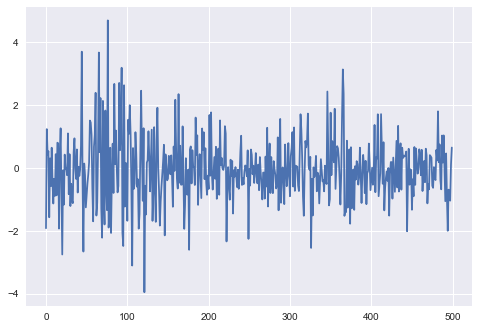

In [2]:
data = pd.read_csv('seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
y = data.logreturn.values

fig, ax = plt.subplots()
ax.plot(y)

### 2. Likelihood estimation with the bootstrap particle filter 


In [3]:
def loglik_bpf(y, N, theta, resample=True, logweights=True):
    # Cumulatively build up log-likelihood
    ll = 0.0
    
    # Initialisation
    phi = theta[0]
    sigma = theta[1]
    beta = theta[2]
    
    samples = stats.norm.rvs(0, np.power(sigma,2), N)
    weights = 1 / N * np.ones((N,))
    weights_normalized =  weights

    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        if resample:
            # Randomly choose ancestors
            ancestors = np.random.choice(samples, size=N, 
                                                     replace=True, p=weights_normalized)
        else:
            ancestors = samples
        
        # Propagate
        samples = phi*ancestors+stats.norm.rvs(0, 1, N)*sigma
        
        if logweights:
            # Weight
            weights = stats.norm.logpdf(y[t], loc=0, 
                                        scale=(beta*np.exp(samples / 2)))
            # Calculate the max of the weights
            max_weights = np.max(weights)
            # Subtract the max
            weights = weights - max_weights
            # Update log-likelihood
            ll += max_weights + np.log(np.sum(np.exp(weights))) - np.log(N)

            # Normalize weights to be probabilities
            weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
        else:
            # Weight
            weights = stats.norm.pdf(y[t], loc=0, 
                                     scale=(beta*np.exp(samples/2)))
            # Update log-likelihood
            ll += np.log(np.sum(weights)) - np.log(N)

            # Normalize weights to be probabilities
            weights_normalized = weights / np.sum(weights)
        
    return ll

### 3. Particle Metropolis Hasting estimator

A Gaussian random walk proposal is used $q(\theta'\,\big|\,\theta[k - 1]) = \mathcal{N}\left(\theta';\,\theta[k - 1], \Sigma\right)$ with appropriately chosen $\Sigma$.

In [4]:
def invgamma_logpdf(x,a,b):
    out = a*np.log(b) - np.log(math.gamma(a)) - (a+1)*np.log(x) - b/x;
    return out

In [145]:
def particle_metropolis_hastings(y, theta_init, M, N, Sigma):
    
    # Fixed parameter
    phi = 0.985
    a = 0.01
    b = 0.01
    
    # Allocate matrices
    theta = np.zeros((M+1,3))
    theta[:,0] = np.power(phi,2)
    theta_prop = np.zeros((M,3))
    theta_prop[:,0] = np.power(phi,2)
    alpha = np.zeros((M,))
    alpha_accepted = np.zeros((M,))
    z = np.zeros((M+1,))
    
    # Initial state
    theta[0,1:] = theta_init   
    z[0] = loglik_bpf(y,N,theta[0,:])
        
    # Iterate the chain
    t = tqdm_notebook(range(M))
    for i in t:
        # Sample a new value
        theta_prop[i,1:] = theta[i,1:]+np.random.multivariate_normal(mean=np.zeros(2),cov=Sigma)
      
        # Sample to be compared to the acceptance probability
        u = stats.uniform.rvs()
        
        # Acceptance probability    
        if ((theta_prop[i,1] > 0.0) & (theta_prop[i,2] > 0.0)):
            z_prop = loglik_bpf(y, N, np.power(theta_prop[i,:],1/2))
            
            # Compute the ratio between the prior distributions (in log-form)
            prior  = invgamma_logpdf(np.power(theta_prop[i,1],1),0.02,b) 
            prior -= invgamma_logpdf(np.power(theta[i,1],1),0.02,b)

            prior += invgamma_logpdf(np.power(theta_prop[i,2],1),a,b) 
            prior -= invgamma_logpdf(np.power(theta[i,2],1),a,b)   
            
            # Compute the acceptance probability
            alpha[i] = np.min((1.0, np.exp(prior+z_prop-z[i])))
            alpha[i] *= theta_prop[i,2] > 0.0
            alpha[i] *= theta_prop[i,2] > 0.0
            
        # Set next state depending on acceptance probability
        if u <= alpha[i]:
            z[i+1] = z_prop
            theta[i+1,:] = theta_prop[i,:]
            alpha_accepted[i] = 1
        else:
            z[i+1] = z[i]
            theta[i+1,:] = theta[i,:]
            
        t.set_postfix({'a_mean': np.mean(alpha[:(i)]),'a_acc_mean':np.mean(alpha_accepted[:(i)])})
            
    return theta, alpha


In [ ]:
M = 7500
burn_in = 2500
theta_init = [0.2**2,1.0**2]
Sigma = np.diag((0.02**4, 0.09**4))
N = 500
theta, alpha = particle_metropolis_hastings(y,theta_init,M,N,Sigma)

0.200139998042
0.99776816349
0.200139998042
0.99776816349


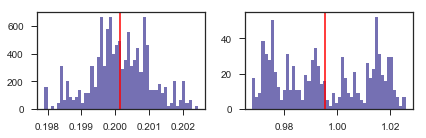

In [148]:
fig, ax = plt.subplots(1,2)

ax[0].hist(np.power(theta[burn_in:M,1],1/2), normed=True, bins=50,facecolor='#7570B3');
ax[0].axvline(np.mean(np.power(theta[burn_in:M,1],1/2)), linewidth=1.5, color='red')

ax[1].hist(np.power(theta[burn_in:M,2],2/2), normed=True, bins=50,facecolor='#7570B3');
ax[1].axvline(np.mean(np.power(theta[burn_in:M,2],2/2)), linewidth=1.5, color='red')

print(np.mean(np.power(theta[burn_in:M,1],1/2)))
print(np.mean(np.power(theta[burn_in:M,2],1/2)))

print(np.mean(np.power(theta[burn_in:M,1],1/2)))
print(np.mean(np.power(theta[burn_in:M,2],1/2)))

fig.set_size_inches(6, 2)
plt.tight_layout()
fig.savefig('hist_svm.pdf')

In [131]:
def simulate(N=500, T=500, resample=True):
    ll = []
    sigma_count = len(np.arange(0.06, 0.3, 0.025))
    theta = [0.985,float('nan'),0.9534];
    for sigma in np.arange(0.06,0.3,0.025):
        theta[1] = sigma;
        for i in range(10):
            ll.append(loglik_bpf(y[:T], N, theta, resample))

    ll = np.transpose(np.reshape(ll, (sigma_count, 10)))
    
    return ll

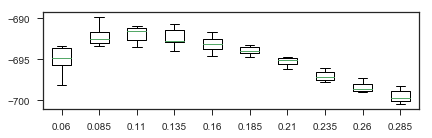

In [132]:
fig, ax = plt.subplots(figsize=(6, 2))
plt.tight_layout()

ax.boxplot(simulate(500, 500), labels=np.arange(0.06,0.3, 0.025));
fig.savefig('ll_pmh_sig.pdf')

In [133]:
def simulate(N=500, T=500, resample=True):
    ll = []
    beta_count = len(np.arange(0.6, 1.2, 0.05))
    theta = [0.985,0.1143,float('nan')];
    for beta in np.arange(0.6,1.2,0.05):
        theta[2] = beta;
        for i in range(10):
            ll.append(loglik_bpf(y[:T], N, theta, resample))

    ll = np.transpose(np.reshape(ll, (beta_count, 10)))
    
    return ll

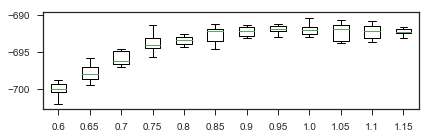

In [134]:
fig, ax = plt.subplots(figsize=(6, 2))
plt.tight_layout()

ax.boxplot(simulate(500, 500), labels=np.arange(0.6,1.2, 0.05));
fig.savefig('ll_pmh_beta.pdf')

In [137]:
np.sqrt(0.02)

0.1414213562373095